### Salish Sea Diatoms
Comparing monthly diatom biomass from Salish Sea Cast (Suchy et al, 2025) with diatoms in Atlantis

In [1]:
import arrow
import os
from datetime import datetime, timedelta
import itertools
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.geometry as sgeom
import xarray as xr
from cartopy import crs, feature
from pathlib import Path
from IPython.display import Image
from shapely.geometry import MultiPoint
from mpl_toolkits.axes_grid1 import make_axes_locatable

from salishsea_tools import data_tools, places, nc_tools, wind_tools

### Read in SalishSeaCast monthly mean diatom biomass from 2007-2020 (Suchy et al., 2025)

In [2]:
ssc_data_path = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Control/"
monthly_array_diatoms_depthint_slicemean = pd.read_csv(ssc_data_path+"SSC201905_monthly_diatoms.csv")
monthly_array_flagellates_depthint_slicemean = pd.read_csv(ssc_data_path+"SSC201905_monthly_flagellate.csv")

In [3]:
ssc_diatom_monthly_mean = monthly_array_diatoms_depthint_slicemean.mean(axis=0)
ssc_diatom_std = monthly_array_diatoms_depthint_slicemean.std(axis=0)

ssc_flagellates_monthly_mean = monthly_array_flagellates_depthint_slicemean.mean(axis=0)
ssc_flagellates_std = monthly_array_flagellates_depthint_slicemean.std(axis=0)

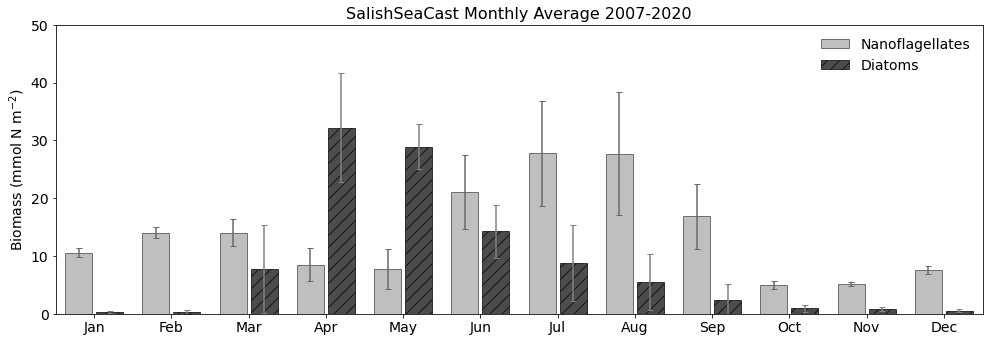

In [4]:
#Check data
fig, ax = plt.subplots(figsize=(14, 5))

fig.tight_layout(pad=2.5)

bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 1}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=np.arange(len(ssc_diatom_monthly_mean)) 

width=0.35

ax.bar(xticks-0.2, ssc_flagellates_monthly_mean,width,yerr=ssc_flagellates_std,color='grey',ecolor='dimgrey',edgecolor='k',label='Nanoflagellates',alpha=0.5,capsize=3) 
ax.bar(xticks + 0.2, ssc_diatom_monthly_mean,width,yerr=ssc_diatom_std,color='k',ecolor='grey',edgecolor='k',hatch='//',alpha=0.7,capsize=3,label='Diatoms') 
ax.set_title('SalishSeaCast Monthly Average 2007-2020',fontsize=16)
ax.legend(frameon=False,loc=1,fontsize=14)
ax.set_ylim(0,50)
ax.set_xlim(-.5,11.5)
ax.set_ylabel('Biomass (mmol N m$^{-2}$)',fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xticks(xticks)
ax.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"));

Use the below if need day-avgeraged diatom biomass

dfile10 = "/ocean/dlatorne/Atlantis/day-avg-diatoms/SalishSeaCast_day_avg_diatoms_20070101_20070110.nc" #mmol N m-3
dfile30 = "/ocean/dlatorne/Atlantis/day-avg-diatoms/SalishSeaCast_day_avg_diatoms_20070101_20070131.nc"
cfile31 = "/ocean/dlatorne/Atlantis/day-avg-diatoms/SalishSeaCast_day_avg_diatoms_compressed_20070101_20070131.nc"

data10 = xr.open_dataset(str(dfile10), decode_cf=True)
data30 = xr.open_dataset(str(dfile30), decode_cf=True)

diatoms_SSC_tzyx = data30.variables["diatoms"] # [t,z, y, x]

diatoms_SSC_tzy = diatoms_SSC_tzyx.mean(axis=3)
diatoms_SSC_tz = diatoms_SSC_tzy.mean(axis=2)
diatoms_ssc = diatoms_SSC_tz.mean(axis=1)*14 #convert from mmol N m-3 to mg N m-3

### Read in corresponding SSAM diatoms for central SoG, 100 m depth-integrated

In [5]:
# Central Strait of Gerorgia
central_sog_boxes = [81,82]

In [6]:
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]
land_df = data_df.loc[land_boxes]
ssc_match_df = data_df.loc[central_sog_boxes]

In [243]:
grid = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
pointList = []
boxCSoGcorners = (450,250), (450, 300), (500,300), (500,250), (450,250) #250, 450
for i in boxCSoGcorners: 
    pointList.append(sgeom.Point(float(grid.nav_lon[i]), float(grid.nav_lat[i])))
bbox = sgeom.Polygon([[p.x, p.y] for p in pointList])


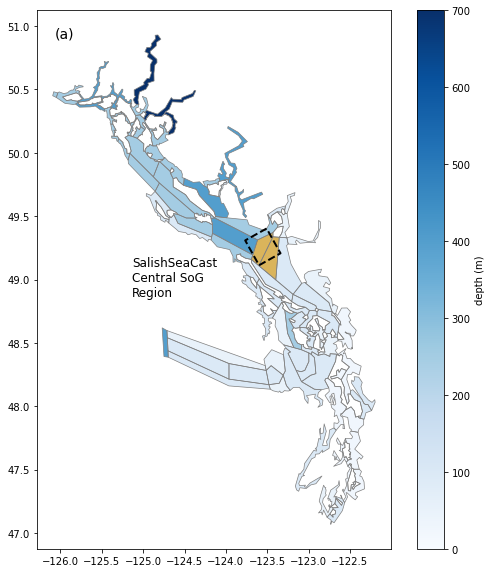

In [244]:
# Atlantis Location Map with SalishSeaCast Box Location
fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 

ax = data_df.plot(column = 'BOTZ', ax=ax, cmap=cm.Blues, cax=cax,
    legend=True, legend_kwds={'label': 'depth (m)'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
ssc_match_df.plot(ax=ax, color='orange',  alpha=0.6, linewidths=0.5, label='matching Atlantis polygons')
land_df.plot(ax=ax, color='white')
#ax.annotate(0.81, 0.55, 'Matching\nAtlantis\nPolygons',transform=ax.transAxes, color='orange', fontsize=12)
ax.text(0.27, 0.47, 'SalishSeaCast\nCentral SoG\nRegion',transform=ax.transAxes, color='black', fontsize=12)
ax.text(0.05, 0.95, '(a)', transform=ax.transAxes, color='black', fontsize=14,) #fontweight='bold'
bbox_gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[bbox])
bbox_gdf = bbox_gdf.to_crs(data_df.crs)
bbox_gdf.boundary.plot(ax=ax, edgecolor='black', linewidths=2, linestyle="--", label='SalishSeaCast\nCentral SoG\nRegion');

In [128]:
#control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/highres-control-3y/outputSalishSea.nc"
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Control/v6719_14y_20250703/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True) #.resample(t='1M').mean()


In [129]:
ssam_diatom_tbl = control.Diatom_N[:, central_sog_boxes, 3:6] # 100 m
ssam_diatom_tb = ssam_diatom_tbl.sum(axis=2)
ssam_diatom_t = ssam_diatom_tb.sum(axis=1)

ssam_picos_tbl = control.PicoPhytopl_N[:, central_sog_boxes, 3:6] # 100 m
ssam_picos_tb = ssam_picos_tbl.sum(axis=2)
ssam_picos_t = ssam_picos_tb.sum(axis=1)

In [130]:
# Biomass of picos much higher than diatoms in SSAM for this region. Correction for biomass to examine pattern.
ssam_diatom_t_corrected = (ssam_diatom_t-ssam_diatom_t.min())/2
ssam_picos_t_corrected = (ssam_picos_t-ssam_picos_t.min())/50

In [131]:
ssam_diatom_monthly_mean = ssam_diatom_t_corrected.groupby("t.month").mean("t")
ssam_picos_monthly_mean = ssam_picos_t_corrected.groupby("t.month").mean("t")


In [132]:
ssam_diatom_std = ssam_diatom_t_corrected.groupby("t.month").std("t")
ssam_picos_std = ssam_picos_t_corrected.groupby("t.month").std("t")

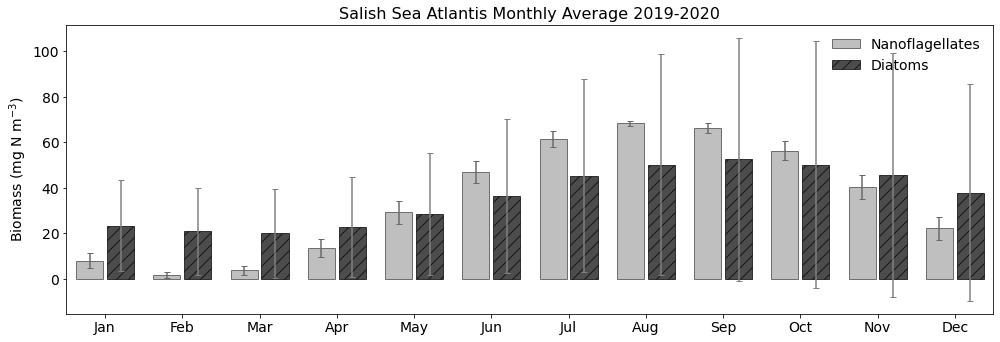

In [77]:
#Check data
fig, ax = plt.subplots(figsize=(14, 5))

fig.tight_layout(pad=2.5)

bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 1}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=np.arange(len(ssc_diatom_monthly_mean)) 

width=0.35

ax.bar(xticks-0.2, ssam_picos_monthly_mean,width,yerr=ssam_picos_std,color='grey',ecolor='dimgrey',edgecolor='k',label='Nanoflagellates',alpha=0.5,capsize=3) 
ax.bar(xticks + 0.2, ssam_diatom_monthly_mean,width,yerr=ssam_diatom_std,color='k',ecolor='grey',edgecolor='k',hatch='//',alpha=0.7,capsize=3,label='Diatoms') 
ax.set_title('Salish Sea Atlantis Monthly Average 2019-2020',fontsize=16)
ax.legend(frameon=False,loc=1,fontsize=14)
#ax.set_ylim(0,50)
ax.set_xlim(-.5,11.5)
ax.set_ylabel('Adjusted Biomass (mg N m$^{-3}$)',fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xticks(xticks)
ax.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"));

### Comparison figures

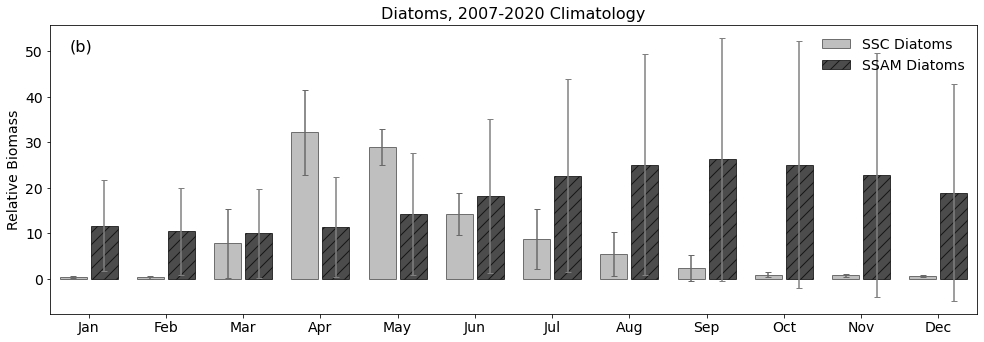

In [241]:
# Diatom biomass
fig, ax = plt.subplots(figsize=(14, 5))

fig.tight_layout(pad=2.5)

bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 1}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=np.arange(len(ssc_diatom_monthly_mean)) 

width=0.35

ax.bar(xticks-0.2, ssc_diatom_monthly_mean,width,yerr=ssc_diatom_std,color='grey',ecolor='dimgrey',edgecolor='k',label='SSC Diatoms',alpha=0.5,capsize=3) #wheat
#ax.fill_between(xticks,NPGO_C_F_mean,color='dimgrey',alpha=.2,label='Nanoflagellates') #wheat
ax.bar(xticks + 0.2, ssam_diatom_monthly_mean/2,width,yerr=ssam_diatom_std/2,color='k',ecolor='grey',edgecolor='k',hatch='//',alpha=0.7,capsize=3,label='SSAM Diatoms') #lightgreen
#ax.fill_between(xticks,NPGO_C_D_mean,color='black',hatch='//',alpha=.3,label='Diatoms') #lightgreen
ax.set_title('Diatoms, 2007-2020 Climatology',fontsize=16)
ax.legend(frameon=False,fontsize=14, loc="upper right")
#ax.set_ylim(0,50)
ax.set_xlim(-.5,11.5)
ax.set_ylabel('Relative Biomass',fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.text(-.25, 50, "(b)", color='k',fontsize=16)
ax.set_xticks(xticks)
ax.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"));

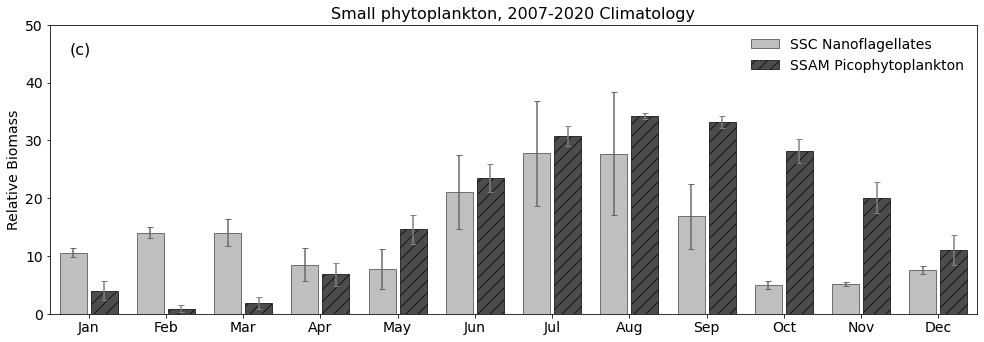

In [240]:
# Picophytoplankton biomass
fig, ax = plt.subplots(figsize=(14, 5))

fig.tight_layout(pad=2.5)

bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 1}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=np.arange(len(ssc_diatom_monthly_mean)) 

width=0.35

ax.bar(xticks-0.2, ssc_flagellates_monthly_mean,width,yerr=ssc_flagellates_std,color='grey',ecolor='dimgrey',edgecolor='k',label='SSC Nanoflagellates',alpha=0.5,capsize=3) #wheat
#ax.fill_between(xticks,NPGO_C_F_mean,color='dimgrey',alpha=.2,label='Nanoflagellates') #wheat
ax.bar(xticks + 0.2, ssam_picos_monthly_mean/2,width,yerr=ssam_picos_std/2,color='k',ecolor='grey',edgecolor='k',hatch='//',alpha=0.7,capsize=3,label='SSAM Picophytoplankton') #lightgreen
#ax.fill_between(xticks,NPGO_C_D_mean,color='black',hatch='//',alpha=.3,label='Diatoms') #lightgreen
ax.set_title('Small phytoplankton, 2007-2020 Climatology',fontsize=16)
ax.legend(frameon=False,fontsize=14,loc='upper right') 
ax.set_ylim(0,50)
ax.set_xlim(-.5,11.5)
ax.set_ylabel('Relative Biomass',fontsize=14) 
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.text(-.25, 45, "(c)", color='k',fontsize=16)
ax.set_xticks(xticks)
ax.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"));

### Comparison of SSAM Plankton to HPLC Data (Nemcek et al., 2023)

In [63]:
data_path = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Control/"
plankton_hplc_data = pd.read_csv(data_path+"Salish_Sea_Plankton_data.csv")


In [161]:
diatom_hplc_station_mean = plankton_hplc_data.groupby("Lon")["total diatoms"].mean()

In [162]:
diatom_hplc_station_mean

Lon
-125.149    8.350000
-125.148    0.135000
-125.147    0.312222
-125.146    0.707500
-125.145    0.060000
              ...   
-122.902    1.880000
-122.892    0.150000
-122.878    0.050000
-122.877    3.690000
-122.875    3.106667
Name: total diatoms, Length: 214, dtype: float64

In [143]:
plankton_hplc_monthly_mean

,DayOfYear,Lat,Lon,Depth.Bottom,SampleNum,Pressure,Temperature,Salinity,DO2,MLD_bvfnoSmooth,...,cryptophytes,auto dinoflagellates,prymnesiophytes,dictyochophytes,raphidophytes,chlorophytes,euglenophytes,UID autotroph,unidentified dinoflagellates,unidentified flagellates
Date.Time,,,,,,,,,,,,,,,,,,,,,
10/1/15 11:37,274.0,48.231,-122.975,129.0,108.0,2.8,11.05,31.51,4.08,89.0,...,77.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,21.0,86.0
10/1/15 13:33,275.0,48.380,-123.044,149.0,119.0,2.7,10.62,31.23,3.83,81.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/1/15 21:19,275.0,48.773,-123.027,210.0,133.0,2.3,11.78,28.94,4.53,6.0,...,187.0,24.0,17.0,14.0,0.0,0.0,0.0,0.0,38.0,260.0
10/1/15 2:25,274.0,48.263,-123.719,179.0,77.0,2.5,9.89,32.27,3.63,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/1/15 6:30,274.0,48.234,-123.302,117.0,87.0,2.2,10.88,31.48,4.15,86.0,...,190.0,20.0,0.0,6.0,0.0,0.0,2.0,0.0,33.0,150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9/9/18 20:14,253.0,49.884,-124.992,310.0,408.0,3.1,11.00,29.41,4.64,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9/9/18 22:31,253.0,49.728,-124.681,352.0,411.0,3.1,14.99,28.07,5.69,26.0,...,683.0,29.0,67.0,25.0,0.0,4.0,4.0,142.0,79.0,400.0
9/9/18 23:29,253.0,49.708,-124.724,300.0,418.0,2.8,12.19,28.96,4.88,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [245]:
print('using data from '+ str(ssam_diatom_t.t[976])+' to '+str(ssam_diatom_t.t[1585]))

using data from <xarray.DataArray 't' ()>
array('2015-01-02T14:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    t        datetime64[ns] 2015-01-02T14:00:00 to <xarray.DataArray 't' ()>
array('2020-01-03T14:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    t        datetime64[ns] 2020-01-03T14:00:00


In [32]:
plankton_hplc_data['Diatoms1'].size

721

In [35]:
ssam_diatom_t[976:1697].size

721

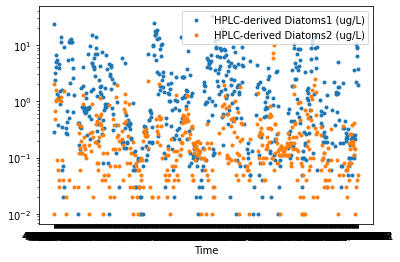

In [136]:
plt.semilogy(plankton_hplc_data['Date.Time'], plankton_hplc_data['Diatoms1'], '.')
#plt.scatter(control.t[976:1585], ssam_diatom_t[976:1585])
plt.semilogy(plankton_hplc_data['Date.Time'], plankton_hplc_data['Diatoms2'], '.')
plt.xlabel('Time')
#plt.ylabel()
#plt.title('Comparison of Diatoms')
plt.legend(['HPLC-derived Diatoms1 (ug/L)','HPLC-derived Diatoms2 (ug/L)']) #'Atlantis Diatoms (mg N/m${^3}$)',
plt.show()

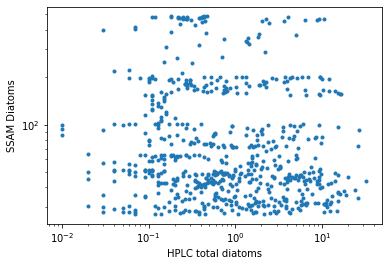

In [138]:
plt.loglog(plankton_hplc_data['total diatoms'], ssam_diatom_t[976:1697], '.')
#plt.scatter(control.t[976:1585], ssam_diatom_t[976:1585])
#plt.scatter(plankton_hplc_data['Date.Time'], plankton_hplc_data['Diatoms2'])
plt.xlabel('HPLC total diatoms')
plt.ylabel('SSAM Diatoms')
#plt.title('Comparison of Diatoms')
#plt.legend(['HPLC-derived Diatoms1 (ug/L)','Atlantis Diatoms (mg N/m${^3}$)','HPLC-derived Diatoms2 (ug/L)'])
plt.show()

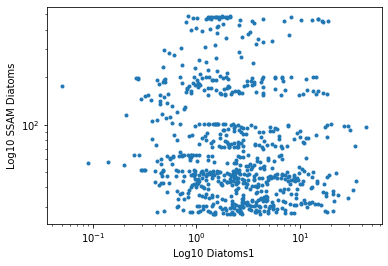

In [123]:
plt.loglog(plankton_hplc_data['Chlorophyll'], ssam_diatom_t[976:1697], '.')
#plt.scatter(control.t[976:1585], ssam_diatom_t[976:1585])
#plt.scatter(plankton_hplc_data['Date.Time'], plankton_hplc_data['Diatoms2'])
plt.xlabel('Log10 Diatoms1')
plt.ylabel('Log10 SSAM Diatoms')
#plt.title('Comparison of Diatoms')
#plt.legend(['HPLC-derived Diatoms1 (ug/L)','Atlantis Diatoms (mg N/m${^3}$)','HPLC-derived Diatoms2 (ug/L)'])
plt.show()

In [ ]:
plt.semilogy(diatom_hplc_station_mean, '.')
plt.semilogy(data_df.BOUNDARY.get.lons, data_df['diatoms'], '.')
#plt.scatter(plankton_hplc_data['Date.Time'], plankton_hplc_data['Diatoms2'])
plt.xlabel('Longitude')
plt.ylabel('Diatoms')
#plt.title('Comparison of Diatoms')
plt.legend(['HPLC-derived total diatoms (ug/L)','Atlantis Diatoms (mg N/m${^3}$)'])
plt.show()

In [ ]:
ssam_diatom_df_tbl = control.Diatom_N[976:1585, :, 3:6] # 100 m
ssam_diatom_df_tb = ssam_diatom_df_tbl.sum(axis=2)
ssam_diatom_df_b = ssam_diatom_df_tb.mean(axis=0)

In [166]:
data_df['diatoms'] = ssam_diatom_df_b

In [168]:
data_df

,cat,BOUNDARY,BOTZ,Region,Sub_Basins,PSmodel,vertmix,horizmix,PERIMETER,list,AREA,DisplayDep,geometry,diatoms
BOX_ID,,,,,,,,,,,,,,
0,119,1,400,Boundary,Main Basin,No,0.0,1.0,57419.0,NaN,97362056,-1.0,"POLYGON ((-124.71244 48.59717, -124.70793 48.5...",0.134067
1,48,0,50,Juan de Fuca,Main Basin,No,0.0,1.0,19721.0,1.0,655575973,50.0,"POLYGON ((-124.71244 48.59717, -123.52445 48.3...",1226.127670
2,49,0,100,Juan de Fuca,Main Basin,No,0.0,1.0,14480.0,2.0,682702420,100.0,"POLYGON ((-124.70793 48.54075, -123.96270 48.3...",12059.936249
3,120,0,100,Juan de Fuca,Main Basin,No,0.0,1.0,20347.0,NaN,494069246,100.0,"POLYGON ((-124.69970 48.43773, -123.96270 48.2...",1487.350218
4,37,0,100,Juan de Fuca,Main Basin,No,0.0,1.0,96558.0,4.0,446328916,100.0,"POLYGON ((-123.51285 48.28257, -123.47959 48.1...",3322.031999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,114,0,0,Island,Johnson strait island,No,0.0,1.0,46792.0,NaN,60940418,0.0,"POLYGON ((-125.12770 50.12882, -125.14511 50.1...",0.000000
126,115,0,0,Island,Johnson strait island,No,0.0,1.0,69501.0,NaN,144127317,0.0,"POLYGON ((-124.92793 50.18117, -124.89472 50.1...",0.000000
127,116,0,0,Island,Johnson strait island,No,0.0,1.0,11185.0,NaN,305171650,0.0,"POLYGON ((-124.97876 50.25572, -124.95843 50.2...",0.000000


In [65]:
# Loading the HPLC dataset into a Geopandas Dataframe
plankton_hplc_data_df = pd.read_csv(data_path+"Salish_Sea_Plankton_data.csv")
hplc_df = gpd.GeoDataFrame(
    plankton_hplc_data_df, 
    geometry=gpd.points_from_xy(plankton_hplc_data_df.Lon, plankton_hplc_data_df.Lat),
    crs="EPSG:4326")
hplc_df = hplc_df.to_crs(data_df.crs)

In [67]:
plankton_hplc_data_df.Lon

0     -123.502
1     -123.243
2     -124.733
3     -124.549
4     -124.067
        ...   
716   -122.939
717   -122.903
718   -122.875
719   -122.877
720   -123.055
Name: Lon, Length: 721, dtype: float64

In [66]:
hplc_df['diatoms'] = hplc_df['Diatoms1'] + hplc_df['Diatoms2']

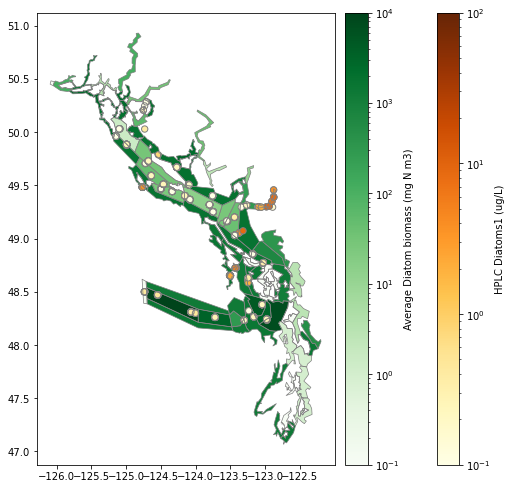

In [121]:
fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
cax2 = divider.append_axes("right", size="5%", pad=0.95) 
ax = data_df.plot(column = 'diatoms', ax=ax, cax=cax, cmap=cm.Greens, #vmax=100,
    norm=colors.LogNorm(vmin=1e-1, vmax=1e4),
    legend=True, legend_kwds={'label': 'Average Diatom biomass (mg N m3)'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
land_df.plot(ax=ax, color='white')

hplc_df.plot(ax=ax, cax=cax2, column='Diatoms1', cmap='YlOrBr', markersize=40, edgecolor='grey', #alpha=0.6,
    norm=colors.LogNorm(vmin=1e-1, vmax=1e2),
    legend=True, legend_kwds={'label': 'HPLC Diatoms1 (ug/L)'},);


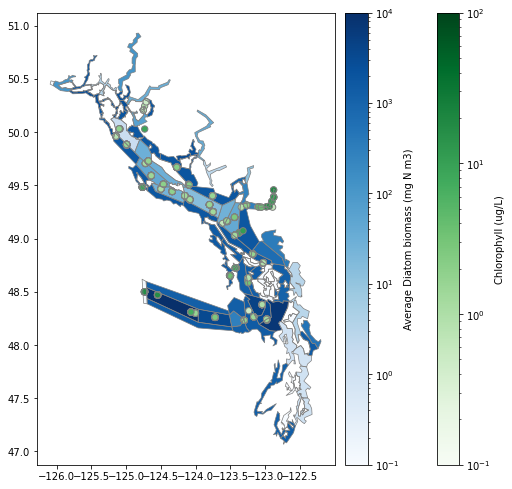

In [122]:
fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
cax2 = divider.append_axes("right", size="5%", pad=0.95) 
ax = data_df.plot(column = 'diatoms', ax=ax, cax=cax, cmap=cm.Blues, #vmax=100,
    norm=colors.LogNorm(vmin=1e-1, vmax=1e4),
    legend=True, legend_kwds={'label': 'Average Diatom biomass (mg N m3)'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
land_df.plot(ax=ax, color='white')

hplc_df.plot(ax=ax, cax=cax2, column='Chlorophyll', cmap='Greens', markersize=40, edgecolor='grey', #alpha=0.6,
    norm=colors.LogNorm(vmin=1e-1, vmax=1e2),
    legend=True, legend_kwds={'label': 'Chlorophyll (ug/L)'},);


In [99]:
ssam_diatom_df_tbl = control.Diatom_N[976:1585, :, 3:6] # 100 m
ssam_diatom_df_tb = ssam_diatom_df_tbl.sum(axis=2)
ssam_diatom_df_b = ssam_diatom_df_tb.mean(axis=0)
ssam_diatom_df_b.size

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

In [62]:
csv_df = pd.read_csv("points.csv")

# Convert to GeoDataFrame
gdf_points = gpd.GeoDataFrame(
    csv_df,
    geometry=gpd.points_from_xy(csv_df.lon, csv_df.lat),
    crs="EPSG:4326"   # adjust if needed
)

# Reproject to match base data CRS
gdf_points = gdf_points.to_crs(data_df.crs)

# Plot points
gdf_points.plot(
    ax=ax,
    column='value',          # column in your CSV to color by
    cmap='Reds',             # pick a contrasting colormap
    markersize=40,           # adjust for visibility
    edgecolor='black',
    legend=True,             # adds a separate colorbar
    legend_kwds={'label': 'CSV values'}

,Cruise,Date.Time,DayOfYear,Station,Lat,Lon,Depth.Bottom,SampleNum,Pressure,Temperature,...,prymnesiophytes,dictyochophytes,raphidophytes,chlorophytes,euglenophytes,UID autotroph,unidentified dinoflagellates,unidentified flagellates,Dominant Species,geometry
0,2015-017,4/1/15 23:42,92,SI,48.652,-123.502,187,9,1.5,9.92,...,,,,,,,,,,None
1,2015-017,4/2/15 3:24,92,59,48.630,-123.243,233,23,2.1,9.11,...,0,5,0,0,1,6,11,149,Skeletonema costatum,None
2,2015-017,4/2/15 15:23,93,102,48.500,-124.733,254,37,1.6,10.45,...,0,0,0,0,8,0,16,163,Skeletonema costatum,None
3,2015-017,4/2/15 18:19,93,75,48.469,-124.549,226,51,1.9,9.57,...,,,,,,,,,,None
4,2015-017,4/2/15 23:03,93,72,48.308,-124.067,186,64,1.7,10.99,...,0,0,0,0,0,0,16,113,Skeletonema costatum,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,2019-062,10/5/19 13:46,279,IND0,49.305,-122.939,31,349,2.5,12.53,...,,,,,,,,,,None
717,2019-062,10/5/19 14:32,279,IND2,49.350,-122.903,153,361,2.3,12.84,...,,,,,,,,,,None
718,2019-062,10/5/19 15:53,279,IND4,49.388,-122.875,220,375,2.1,12.91,...,12,58,0,0,0,167,58,562,Skeletonema costatum,None
719,2019-062,10/5/19 18:01,279,IND7,49.457,-122.877,75,389,2.3,13.23,...,,,,,,,,,,None


<AxesSubplot:>

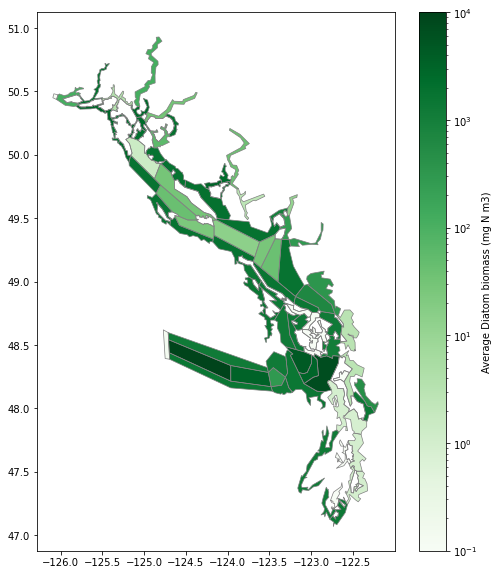

In [96]:
fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
ax = data_df.plot(column = 'diatoms', ax=ax, cax=cax, cmap=cm.Greens, #vmax=100,
    norm=colors.LogNorm(vmin=1e-1, vmax=1e4),
    legend=True, legend_kwds={'label': 'Average Diatom biomass (mg N m3)'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
land_df.plot(ax=ax, color='white')
#ssc_match_df.plot(ax=ax, color='orange',  alpha=0.6, linewidths=0.5)

#ax.plot(plankton_hplc_data_df['Lon'],plankton_hplc_data_df['Lat'],plankton_hplc_data_df['Diatoms2'])